In [ ]:
import dask.dataframe as dd
import re
import json

# ——— CONFIG ———
DD_PATH = '../Step_3_analysis/cleaned_data_polars/70.parquet'   # adjust to your parquet files
TOP_N   = 5                             # how many top reviews per theme
# 1. Define your themes & compile regexes
themes = {
    # Core moment‑to‑moment play
    'gameplay': [
        'gameplay', 'mechanics', 'tactical shooter', 'precision', 'aim',
        'headshot', 'spray‑control', 'burst‑fire', 'recoil', 'crosshair',
        'peek', 'counter‑strafe', 'movement', 'jump‑peek', 'clutch',
        'bomb plant', 'defuse', 'round', 'eco‑round', 'overtime'
    ],

    # Weapons, grenades, recoil patterns
    'weapons': [
        'weapon', 'gun', 'rifle', 'ak', 'm4', 'awp', 'pistol', 'deagle',
        'smg', 'shotgun', 'sniper', 'knife', 'grenade', 'flashbang',
        'smoke', 'molotov', 'he‑nade', 'incendiary', 'zeus', 'spray',
        'pull‑out time', 'reload'
    ],

    # Map design and call‑outs
    'maps': [
        'map', 'layout', 'bombsite', 'call‑out', 'rotation', 'angles',
        'cover', 'line‑up', 'utility spot', 'choke‑point', 'dust2',
        'mirage', 'inferno', 'nuke', 'overpass', 'ancient', 'vertigo',
        'office', 'train', 'cache'
    ],

    # Ranked play, esport angle, organised competition
    'competitive': [
        'competitive', 'matchmaking', 'rank', 'elo', 'premier', 'global elite',
        'silver', 'faceit', 'esport', 'tournament', 'major', 'league',
        'teamplay', 'strat', 'timeout', 'coach', 'demo review', 'practice'
    ],

    # Game economy, skins, trading and cases
    'economy & skins': [
        'economy', 'money', 'buy', 'force', 'save', 'full‑buy', 'bonus‑loss',
        'skin', 'knife skin', 'case', 'capsule', 'stattrak', 'souvenir',
        'sticker', 'trade‑up', 'market', 'auction', 'rarity', 'float value',
        'pattern', 'lootbox'
    ],

    # Anti‑cheat and integrity concerns
    'anti_cheat': [
        'cheater', 'cheat', 'hacker', 'hack', 'wallhack', 'aimbot', 'spinbot',
        'vac', 'vac ban', 'prime', 'overwatch', 'smurf', 'rage', 'backtracking',
        'triggerbot', 'report', 'banwave', 'trust factor'
    ],

    # Performance, networking and technical stability
    'performance': [
        'fps', 'frame rate', 'stutter', 'lag', 'ping', 'tickrate', 'sub‑tick',
        'server', 'hit‑reg', 'netcode', 'desync', 'packet loss', 'freeze',
        'crash', 'memory leak', 'loading time', 'update', 'patch', 'driver'
    ],

    # Visual fidelity and art direction
    'visuals': [
        'visuals', 'graphics', 'shader', 'lighting', 'smoke effect',
        'blood splatter', 'particle', 'texture', 'model', 'animation',
        'ui', 'hud', 'crosshair style', 'ray tracing', 'color', 'resolution',
        'fov', 'viewmodel'
    ],

    # Audio design and voice comms
    'audio': [
        'audio', 'sound', 'footstep', 'sound cue', 'directional',
        'occlusion', 'gunshot', 'reverb', 'bomb beep', 'defuse sound',
        'voice chat', 'callout', 'microphone', 'radio command', 'volume',
        'sound bug', 'muffle', 'mix'
    ],

    # Social experience and community features
    'community': [
        'community', 'friends', 'lobby', 'party', 'team‑mate', 'toxic',
        'grief', 'vote kick', 'chat', 'text chat', 'mute', 'spray logo',
        'workshop', 'community server', 'surf', 'bhop', 'mods', 'plugin',
        'custom map', 'training map'
    ]
}


def slugify(name):
    return name.lower().replace(' ', '_')

# 2. Read only the columns we need
df = dd.read_parquet(DD_PATH, columns=['review', 'votes_up'])

# 3. Normalize text
df['review'] = df['review'].fillna('').str.lower()

# 4. For each theme, build a regex string and flag rows
for theme, words in themes.items():
    pat = r'\b(?:' + '|'.join(map(re.escape, words)) + r')\b'
    col = f"is_{slugify(theme)}"
    df[col] = df['review'].str.contains(pat,
                                             flags=re.IGNORECASE,
                                             regex=True)

# 5. Persist so subsequent operations reuse cached partitions
df = df.persist()

# 6. Compute total counts per theme
bool_cols = [f"is_{slugify(t)}" for t in themes]
counts_series = df[bool_cols].sum().compute()

theme_counts = {
    theme: int(counts_series[f"is_{slugify(theme)}"])
    for theme in themes
}

# 7. Extract top-N reviews by votes_up for each theme
top_reviews = {}
for theme in themes:
    col = f"is_{slugify(theme)}"
    # filter, sort, and grab top N
    top_df = (
        df[df[col]]
        .nlargest(TOP_N, 'votes_up')[['review', 'votes_up']]
        .compute()
    )
    # convert to list of dicts
    top_reviews[theme] = top_df.to_dict(orient='records')

# 8. Bundle and save
summary = {
    'theme_counts': theme_counts,
    'top_reviews':   top_reviews
}

# Print to console
print(json.dumps(summary, indent=2))

# Optionally write out for your dashboard/front-end
with open('review_theme_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

# Using Dask

In [ ]:
import dask.dataframe as dd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition          import NMF
import numpy as np
import pandas as pd

def process_game(df, text_col='review', n_topics=8, sample_size=50000):
    """
    1) Sample reviews for this game
    2) Vectorize with TF–IDF
    3) Fit NMF to discover `n_topics`
    4) Assign every review to its dominant topic
    5) Return:
       - topics: dict topic_id -> top-terms
       - counts: how many reviews per topic
       - reps:   one representative review per topic
    """
    # A) Sample into Pandas
    total = df[text_col].dropna().count().compute()
    frac  = min(1.0, sample_size / total)
    sample = (
        df[text_col]
          .dropna()
          .sample(frac=frac, random_state=0)
          .compute()
          .tolist()
    )
    
    # B) TF–IDF on sample
    vect = TfidfVectorizer(
        max_features=15_000,
        stop_words='english',
        ngram_range=(1,2)
    )
    X = vect.fit_transform(sample)               # shape (n_samples, n_feats)
    
    # C) NMF for topics
    nmf = NMF(n_components=n_topics, random_state=0)
    W   = nmf.fit_transform(X)                   # (n_samples, n_topics)
    H   = nmf.components_                        # (n_topics,  n_feats)
    
    feat_names = vect.get_feature_names_out()
    topics = {
        t: [feat_names[i] for i in H[t].argsort()[-10:][::-1]]
        for t in range(n_topics)
    }
    
    # D) Assign every review in the full Dask DataFrame
    #    (transform in batches if too big)
    #    Here we do a quick Pandas assignment for demonstration:
    all_docs = df[text_col].dropna().compute().tolist()
    X_all    = vect.transform(all_docs)
    W_all    = nmf.transform(X_all)
    labels   = np.argmax(W_all, axis=1)
    
    # E) Compute counts and pick one representative review per topic
    counts = pd.Series(labels).value_counts().to_dict()
    reps   = {}
    for t in range(n_topics):
        idxs = np.where(labels==t)[0]
        reps[t] = all_docs[idxs[0]] if len(idxs) else ""
    
    return {
        'topics':      topics,
        'topic_counts': counts,
        'representative': reps
    }

# — example usage for one game —
DD_PATH = '../Step_3_analysis/cleaned_data_polars/*.parquet'
df = dd.read_parquet(DD_PATH, 
                     columns=['review','voted_up','review_language'])
df = df[df['review_language']=='english'].persist()

insights = process_game(df, n_topics=6)

print("Discovered topics:", insights['topics'])
print("Counts per topic:", insights['topic_counts'])
print("Example per topic:")
for t, doc in insights['representative'].items():
    print(f" • Topic {t}: {doc[:120]}…")


# Using Python

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import numpy as np
import pandas as pd
import os
import glob

def process_game(reviews_list, text_col='review', n_topics=8, sample_size=50000):
    """
    Process a list of reviews to extract topics
    
    Parameters:
    - reviews_list: List of review texts
    - text_col: Column name (only used for clarity in the function signature)
    - n_topics: Number of topics to extract
    - sample_size: Maximum number of reviews to sample for topic modeling
    
    Returns dict with topics, counts and representative reviews
    """
    # Filter out None values
    reviews_list = [r for r in reviews_list if r is not None]
    
    # A) Sample from reviews
    total = len(reviews_list)
    frac = min(1.0, sample_size / total)
    if frac < 1.0:
        # Random sampling if we have more reviews than sample_size
        sample = pd.Series(reviews_list).sample(n=sample_size, random_state=0).tolist()
    else:
        # Use all reviews if fewer than sample_size
        sample = reviews_list
    
    # B) TF–IDF on sample
    vect = TfidfVectorizer(
        max_features=15_000,
        stop_words='english',
        ngram_range=(1,2)
    )
    X = vect.fit_transform(sample)               # shape (n_samples, n_feats)
    
    # C) NMF for topics
    nmf = NMF(n_components=n_topics, random_state=0)
    W = nmf.fit_transform(X)                     # (n_samples, n_topics)
    H = nmf.components_                          # (n_topics,  n_feats)
    
    feat_names = vect.get_feature_names_out()
    topics = {
        t: [feat_names[i] for i in H[t].argsort()[-10:][::-1]]
        for t in range(n_topics)
    }
    
    # D) Assign every review
    X_all = vect.transform(reviews_list)
    W_all = nmf.transform(X_all)
    labels = np.argmax(W_all, axis=1)
    
    # E) Compute counts and pick one representative review per topic
    counts = pd.Series(labels).value_counts().to_dict()
    reps = {}
    for t in range(n_topics):
        idxs = np.where(labels==t)[0]
        reps[t] = reviews_list[idxs[0]] if len(idxs) else ""
    
    return {
        'topics': topics,
        'topic_counts': counts,
        'representative': reps
    }

# Example usage processing files sequentially
def process_parquet_directory(directory_path, language='english', n_topics=6):
    # Get list of all parquet files in the directory
    parquet_files = glob.glob(os.path.join(directory_path, '*.parquet'))
    
    # Collect all reviews that match the language criteria
    all_english_reviews = []
    
    # Process each file sequentially
    for file_path in parquet_files:
        print(f"Processing {file_path}...")
        
        # Read the parquet file
        df = pd.read_parquet(file_path)
        
        # Filter by language
        english_df = df[df['review_language'] == language]
        
        # Extract non-null reviews and add to our collection
        reviews = english_df['review'].dropna().tolist()
        all_english_reviews.extend(reviews)
        
        print(f"Added {len(reviews)} {language} reviews from {file_path}")
    
    print(f"Total collected reviews: {len(all_english_reviews)}")
    
    # Now process all collected reviews
    insights = process_game(all_english_reviews, n_topics=n_topics)
    
    return insights

# — Run the analysis —
PATH = '../Step_3_analysis/cleaned_data_polars'
insights = process_parquet_directory(PATH, language='english', n_topics=6)

print("Discovered topics:", insights['topics'])
print("Counts per topic:", insights['topic_counts'])
print("Example per topic:")
for t, doc in insights['representative'].items():
    print(f" • Topic {t}: {doc[:120]}…")

# Dask Upgrade

In [ ]:
!pip install sentence-transformers umap-learn hdbscan scikit-learn transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/rgmatr1x/anaconda3/envs/rapids-25.04/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/rgmatr1x/anaconda3/envs/rapids-25.04/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/rgmatr1x/anaconda3/envs/rapids-25.04/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/rgmatr1x/anaconda3/envs/rapids-25.04/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling paralleli

Sentiment,Cluster,Count,Keywords,Example Review,Summary
Likes,45,1210,"kill, game, scientist, alien, kill kill, aliens, scientists, science, like, shoot",Pros I got to be a soldier a scientist a space warrior a crowbarweilding maniac and a Ghostbuster at the same time Shot nearly everything in the game including the people trying to help me Cons In a facility practically overflowing with deadly weaponry only one scientist thought to actually arm himself Ive become deathly paranoid about laboratories Any time Im in one I start checking under the tables for headcrabs Highly recommended,I got to be a soldier a scientist a space warrior a crowbarweilding maniac and a Ghostbuster at the same time . Shot nearly everything in the game including the people trying
Likes,14,588,"yes, yes yes, sure yes, yes sure, sure, yes sir, sir, yes course, course yes, course",Yes,"Yes Yes . Yes. Yes . No. Yes. No. yes . Yes . ""Yes"" Yes ."
Likes,60,287,"life, half, half life, halflife, life half, want, better, want half, life want, like",there are 3 half life packs half life half life anthology and half life complete i have three friends who play dis game half life is on 3 platforms tags include single player multi player and valve anti cheat enabled it is a fps fps is 3 letters aliens are enemies from xen xen is 3 letters i can count to three half life 3 confirmed 33 3 of 3 people found this helpful,there are 3 half life packs half life . half life is on 3 platforms tags include single player multi player and valve anti cheat enabled it is a fps fps is 3 letters aliens are enemies
Likes,41,166,"haf, lif, life, half, haf lif, hlaf, hal, haf life, hafl, life haf",hlaf ife,"hlaf ife ife: ""Hlafif ife"" is a term of honor for a person who dies in a car ."
Likes,59,951,"game, 1010, great, good, play, games, best, game 1010, story, fun",20 minutes into the game got killed by a bookcase 1010,20 minutes into the game got killed by a bookcase 20 minutes after the game .
Likes,32,108,"1010, 1010 1010, ign 1010, ign, 1010 ign, wowza throwback1998, throwback1998 1010, wowza, shepard 1010, shepard",1010 Period,1010 Period. 1010 period . 1000 period. 10100 period . 10100 Period . 1010 periods. 1011 period . 1020 Period .
Likes,54,361,"game, best, best game, played, games, ive, best games, ive played, played best, greatest",Basically its the best game made before the best game made was made,The best game was made before the best game made was made . Basically its the best of the game made before being made .
Likes,69,3469,"game, halflife, life, half, games, half life, play, time, like, just",61 hrs on record Dont trust that its clearly wrong haha Halflife is what started it for me Yeah sure I could say Doom is what started PC gaming for me and of course you cant forget Quake Wolfenstein Redneck rampage etc but HalfLife is what locked me firmly in place I still think of the times back then when I used to wake up at 6am on a Saturday to play some HalfLife and Starcraft and watch Pokemon That feeling is something that I cant replicate today Perhaps its nostalgia but that carefree feeling of being a kid and enjoying such an insane game is one of my fondest memories of growing up Not only was the single player insane to my ten year old mind back then but the countless mods that spawned because of this game and the fun times I had Some that immediately come to mind Pirates Vikings and Knights Vampire Slayer Battlegrounds The Specialists Brainbread The list is long and goes on and on Yeah yeah dont worry I didnt forget about CS Thats reserved for its own review I still have floppy disks filled with updates skin packs and bots that I downloaded from csnation Any of you remember countercrap RzE Rizzuh Lungfish The infamous myg0t cheating clan thatd youd occasionally run into P I recently cycled through some of the older games like Deathmatch Classic Team Fortress and Day of Defeat I was pleasantly surprised to see people still playing them It just goes to show you that H

<Figure size 800x500 with 0 Axes>

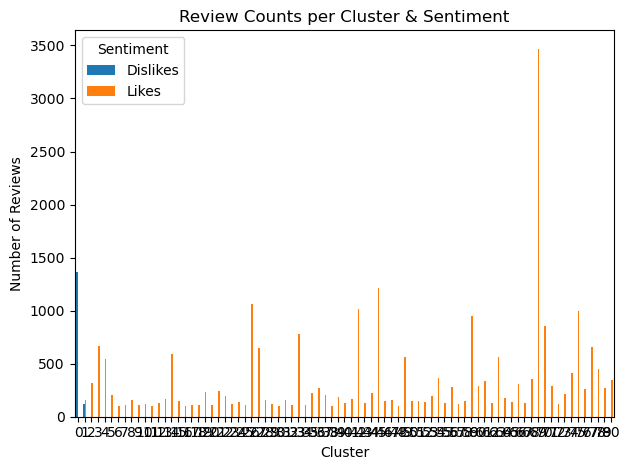

In [3]:
# Cell 1: Install dependencies (run once)
!pip install sentence-transformers umap-learn hdbscan scikit-learn transformers dask pandas matplotlib

# Cell 2: Imports
import torch
import dask.dataframe as dd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
from transformers import pipeline

# Cell 3: Configuration & Data Load
DF_PATH = '../Step_3_analysis/top_100_parquet/70.parquet'
df = dd.read_parquet(
    DF_PATH,
    columns=['review','votes_up','voted_up','review_language']
)
df = df[df['review_language']=='english'].persist()

def sample_bucket(df,label,n=50000,random_state=42):
    bucket = df[df['voted_up']==label][['review','votes_up']].dropna()
    total = bucket.shape[0].compute()
    frac  = min(1.0, n/total) if total>0 else 0
    sampled = bucket.sample(frac=frac, random_state=random_state).compute() if frac>0 else pd.DataFrame(columns=['review','votes_up'])
    return sampled['review'].tolist(), sampled['votes_up'].tolist()

likes_docs, likes_votes = sample_bucket(df, True)
dis_docs,  dis_votes  = sample_bucket(df, False)

# Cell 4: SBERT Embedding
device = 'cuda' if torch.cuda.is_available() else 'cpu'
embedder = SentenceTransformer('all-MiniLM-L6-v2', device=device)

def encode_docs(docs, batch_size=64):
    embeddings = []
    for i in range(0, len(docs), batch_size):
        embeddings.append(embedder.encode(docs[i:i+batch_size], convert_to_numpy=True))
    return np.vstack(embeddings)

likes_emb = encode_docs(likes_docs)
dis_emb   = encode_docs(dis_docs)

# Cell 5: UMAP + HDBSCAN Clustering
def cluster_labels(embeddings, min_cluster_size=100):
    umap_emb = umap.UMAP(
        n_neighbors=15,
        n_components=10,
        metric='cosine',
        random_state=42
    ).fit_transform(embeddings)
    return hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        metric='euclidean',
        cluster_selection_method='eom'
    ).fit_predict(umap_emb)

likes_labels = cluster_labels(likes_emb)
dis_labels   = cluster_labels(dis_emb)

# Cell 6: Extract Top Keywords per Cluster
def extract_cluster_keywords(docs, labels, top_k=10):
    clusters = defaultdict(list)
    for doc, lab in zip(docs, labels):
        if lab < 0 or not doc.strip(): continue
        clusters[lab].append(doc)

    keywords = {}
    for lab, docs in clusters.items():
        text = " ".join(docs)
        tfidf = TfidfVectorizer(stop_words='english',
                                max_features=50000,
                                ngram_range=(1,2))
        X = tfidf.fit_transform([text]).toarray().ravel()
        terms = tfidf.get_feature_names_out()
        top_idxs = X.argsort()[-top_k:][::-1]
        keywords[lab] = [terms[i] for i in top_idxs]
    return keywords

likes_keywords = extract_cluster_keywords(likes_docs, likes_labels)
dis_keywords   = extract_cluster_keywords(dis_docs,  dis_labels)

# Cell 7: Assemble Insights
def assemble_insights(docs, labels, votes, keywords):
    counts, best = defaultdict(int), {}
    for doc, lab, v in zip(docs, labels, votes):
        if lab < 0: continue
        counts[lab] += 1
        if lab not in best or v > best[lab][0]:
            best[lab] = (v, doc)

    insights = {}
    for lab, keys in keywords.items():
        insights[lab] = {
            'count': counts.get(lab, 0),
            'keywords': keys,
            'example': best.get(lab, (None, ""))[1]
        }
    return insights

likes_insights = assemble_insights(likes_docs, likes_labels, likes_votes, likes_keywords)
dis_insights   = assemble_insights(dis_docs,  dis_labels,  dis_votes,  dis_keywords)

# Cell 8: Summarization of Example Reviews
summarizer = pipeline(
    'summarization',
    model='sshleifer/distilbart-cnn-12-6',
    device=0 if torch.cuda.is_available() else -1
)

def safe_summarize(text):
    try:
        return summarizer(
            text,
            max_length=40,
            min_length=15,
            do_sample=False,
            truncation=True
        )[0]['summary_text']
    except:
        return text[:200] + '...'

for info in likes_insights.values():
    info['summary'] = safe_summarize(info['example'] or " ".join(info['keywords']))
for info in dis_insights.values():
    info['summary'] = safe_summarize(info['example'] or " ".join(info['keywords']))

# Cell 9: Build DataFrame for Presentation
# Cell 9: Build DataFrame for Presentation
def to_dataframe(insights, sentiment):
    return pd.DataFrame([
        {
            'Sentiment': sentiment,
            'Cluster': lab,
            'Count': data['count'],
            'Keywords': ", ".join(data['keywords']),
            'Example Review': data['example'],
            'Summary': data['summary']
        }
        for lab, data in insights.items()
    ])

df_likes    = to_dataframe(likes_insights,   'Likes')
df_dislikes = to_dataframe(dis_insights,      'Dislikes')
df_all      = pd.concat([df_likes, df_dislikes], ignore_index=True)

# Display as a clean table (hide the index)
display(
    df_all.style
          .set_caption("Review Clusters Insights")
          .hide(axis="index")       # <-- use this instead of hide_index()
)


# Cell 10: Visualization
plt.figure(figsize=(8, 5))
df_all.groupby(['Cluster', 'Sentiment'])['Count'] \
      .sum() \
      .unstack('Sentiment') \
      .plot(kind='bar', rot=0)
plt.title("Review Counts per Cluster & Sentiment")
plt.xlabel("Cluster")
plt.ylabel("Number of Reviews")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()
